# Titanic Factorization Machine

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")

In [35]:
# AWS Specific Imports and Setup

import boto3
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='drake-mle-part-2' # Replace with your s3 bucket name
prefix = 'factorization-machine' # Used as part of the path in the bucket where you store data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) # The URL to access the bucket

raw_titanic_data = 's3://{}/{}'.format(bucket, 'rawTitanic.csv')

print(raw_titanic_data)

s3://drake-mle-part-2/rawTitanic.csv


## Prepare Data

In [36]:
titanic = pd.read_csv(raw_titanic_data)

In [37]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [38]:
titanic.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

In [39]:
sex = {"male": 0, "female": 1}
titanic['Sex'] = titanic['Sex'].map(sex)

In [40]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Rare": 4}
titanic['Title'] = titanic.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# replace titles with a more common title or as Rare
titanic['Title'] = titanic['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                        'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Master'], 'Rare')
titanic['Title'] = titanic['Title'].replace('Mlle', 'Miss')
titanic['Title'] = titanic['Title'].replace('Ms', 'Miss')
titanic['Title'] = titanic['Title'].replace('Mme', 'Mrs')

titanic['Title'] = titanic['Title'].map(titles)

# filling NaN with 0
titanic['Title'] = titanic['Title'].fillna(0)
titanic = titanic.drop(['Name'], axis=1)

(8, 0)

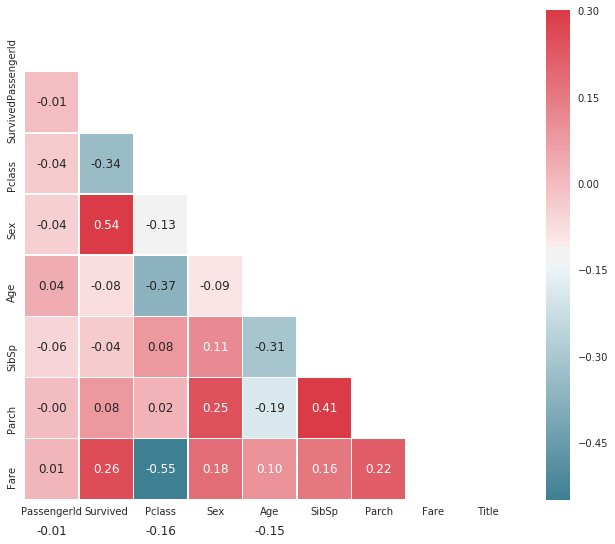

In [41]:
corr = titanic.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, linewidths=0.5, fmt='.2f',ax=ax)
ax.set_ylim(8, 0)

Dropping values that are poorly correlated for simplicity.

In [42]:
titanic = titanic.drop('PassengerId', 1)
titanic = titanic.drop('Ticket', 1)
titanic = titanic.drop('Cabin', 1)
titanic = titanic.drop('Embarked', 1)
titanic = titanic.drop('Age', 1)
titanic = titanic.drop('SibSp', 1)
titanic = titanic.drop('Parch', 1)

In [43]:
titanic.head()

Survived  Pclass  Sex     Fare  Title
0         0       3    0   7.2500      1
1         1       1    1  71.2833      3
2         1       3    1   7.9250      2
3         1       1    1  53.1000      3
4         0       3    0   8.0500      1

In [44]:
titanic.describe()

Survived      Pclass         Sex        Fare       Title
count  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642    0.352413   32.204208    1.702581
std      0.486592    0.836071    0.477990   49.693429    0.957633
min      0.000000    1.000000    0.000000    0.000000    1.000000
25%      0.000000    2.000000    0.000000    7.910400    1.000000
50%      0.000000    3.000000    0.000000   14.454200    1.000000
75%      1.000000    3.000000    1.000000   31.000000    2.000000
max      1.000000    3.000000    1.000000  512.329200    4.000000

In [45]:
titanic.loc[ titanic['Fare'] <= 7.91, 'Fare'] = 0
titanic.loc[(titanic['Fare'] > 7.91) & (titanic['Fare'] <= 14.454), 'Fare'] = 1
titanic.loc[(titanic['Fare'] > 14.454) & (titanic['Fare'] <= 31), 'Fare']   = 2
titanic.loc[(titanic['Fare'] > 31) & (titanic['Fare'] <= 99), 'Fare']   = 3
titanic.loc[(titanic['Fare'] > 99) & (titanic['Fare'] <= 250), 'Fare']   = 4
titanic.loc[ titanic['Fare'] > 250, 'Fare'] = 5
titanic['Fare'] = titanic['Fare'].astype(int)

In [46]:
titanic.head()

Survived  Pclass  Sex  Fare  Title
0         0       3    0     0      1
1         1       1    1     3      3
2         1       3    1     1      2
3         1       1    1     3      3
4         0       3    0     1      1

In [47]:
titanic = pd.get_dummies(titanic, prefix=['Title'], columns=['Title'])
titanic.rename(columns={'Title_1': 'isMr', 'Title_2': 'isMiss', 'Title_3': 'isMrs', 'Title_4': 'isRareTitle'}, inplace=True)
titanic.head()

Survived  Pclass  Sex  Fare  isMr  isMiss  isMrs  isRareTitle
0         0       3    0     0     1       0      0            0
1         1       1    1     3     0       0      1            0
2         1       3    1     1     0       1      0            0
3         1       1    1     3     0       0      1            0
4         0       3    0     1     1       0      0            0

In [48]:
features = titanic.drop('Survived', 1)
labels = titanic['Survived']

train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.33, random_state=42)

Push data to S3

In [49]:
from io import StringIO

test_csv_buffer = StringIO()
train_csv_buffer = StringIO()
pd.concat([test_labels, test], axis=1).to_csv(test_csv_buffer, header=False, index=False)
pd.concat([train_labels, train], axis=1).to_csv(train_csv_buffer, header=False, index=False)

s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, prefix + '/train.csv').put(Body=train_csv_buffer.getvalue())
s3_resource.Object(bucket, prefix + '/validation.csv').put(Body=test_csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '4DDAA64683AA9331',
  'HostId': 'h+BYxlxlgLqHeOsjHV6VaS7vKmr00yyzdWCjWORyPWeB3Psk0Gb+SzENjxaIyAmomIw4/5pSSQc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'h+BYxlxlgLqHeOsjHV6VaS7vKmr00yyzdWCjWORyPWeB3Psk0Gb+SzENjxaIyAmomIw4/5pSSQc=',
   'x-amz-request-id': '4DDAA64683AA9331',
   'date': 'Mon, 13 Jan 2020 05:37:38 GMT',
   'etag': '"662e8d1b1bb961eded9dad735e039dc3"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"662e8d1b1bb961eded9dad735e039dc3"'}

## Train Model

In [50]:
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train.csv')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation.csv')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'factorization_machine_model')

In [51]:
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'factorization-machines')

Once we have the container, now we can create the Estimator, set the hyperparameters, set where the data is coming from, and finally train the model.

In [52]:
fm_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

In [53]:
fm_model.set_hyperparameters(feature_dim=7,
                           predictor_type='binary_classifier',
                           mini_batch_size=200,
                           num_factors=10)

In [54]:
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [55]:
fm_model.fit(inputs=data_channels,  logs=True)

2020-01-13 05:40:13 Starting - Starting the training job...
2020-01-13 05:40:14 Starting - Launching requested ML instances......
2020-01-13 05:41:18 Starting - Preparing the instances for training...
2020-01-13 05:42:10 Downloading - Downloading input data...
2020-01-13 05:42:28 Training - Downloading the training image..Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[01/13/2020 05:42:49 INFO 139984011888448] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method': 


2020-01-13 05:42:59 Uploading - Uploading generated training model
2020-01-13 05:42:59 Completed - Training job completed
Training seconds: 49
Billable seconds: 49


## Deploy Endpoint

In [56]:
fm_predictor = fm_model.deploy(initial_instance_count=1,
                                instance_type='ml.t2.medium',
                                endpoint_name='titanic-survived-factorization-machines'
                                )

---------------------------------------------------------------------------------------------------------------------------------------!